# Auswahl

Stationen: ['Graz-DB', 'Graz-M G', 'Graz-S', 'Graz-O P', 'Graz-N', 'Graz-W','Lustb',]

Features: ['Druck', 'Nierschlag', 'Globalstrahlung', 'Zeit',
       'Wind_Mittel', 'Wind_Max', 'Day sin', 'Day cos', 'Year sin',
       'Year cos']

In [1]:
Ziel = 'Graz-N'
Features = ['Zeit']
Stunden = 6

# Import

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import pymongo

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Daten laden

## Daten in DB laden

In [3]:
conn = pymongo.MongoClient('localhost', 27017)
collection_engineered = conn['testPMP']['engineered']

In [4]:
# laden
exclude_data = {'_id': False}
raw_engineered = list(collection_engineered.find({}, projection=exclude_data))
df = pd.DataFrame(raw_engineered)

## Auswahl Daten

In [5]:
pms = ['Graz-DB', 'Graz-M G', 'Graz-S', 'Graz-O P', 'Graz-N', 'Graz-W',
       'Lustb']
pms.remove(Ziel)
maxs = ['Graz-S_Max', 'Graz-N_Max', 'Graz-W_Max']
maxs.remove(Ziel+'_Max')
mittels = ['Graz-S_Mittel', 'Graz-N_Mittel',
       'Graz-W_Mittel']
mittels.remove(Ziel+'_Mittel')
temps = ['Graz-DB_Temp',
       'Graz-M G_Temp', 'Graz-S_Temp', 'Graz-O P_Temp', 'Graz-N_Temp',
       'Graz-W_Temp']
temps.remove(Ziel+'_Temp')

allfeatures =  ['Druck', 'Nierschlag', 'Globalstrahlung', 'Zeit', 'Day sin', 
                'Day cos', 'Year sin', 'Year cos', 
                Ziel+'_Max', Ziel+'_Mittel', Ziel+'_Temp']

df = df.drop(columns = pms)
df = df.drop(columns = maxs)
df = df.drop(columns = mittels)
df = df.drop(columns = temps)

df = df.drop(columns = [x for x in allfeatures if x not in Features])

In [6]:
df.corr()

,Graz-N,Zeit
Graz-N,1.000000,-0.110925
Zeit,-0.110925,1.000000


### Daten weglassen

Wind_max -> wind_mittel  _> Globalstrahlung 

In [7]:
df = df.drop(columns=[])
df.corr()

,Graz-N,Zeit
Graz-N,1.000000,-0.110925
Zeit,-0.110925,1.000000


In [8]:
name = '2_L:' + Ziel + '__'+ '_'.join([str(elem) for elem in df.columns]) 

## Teilen in Trainings-, Validierungs und Testdaten

In [9]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

Speichern der Durchschnittswerte und Standardabweichungen für die Trainingsdaten: Zur Verwendung in der Runtime

In [10]:
train_mean = train_df.mean()
train_std = train_df.std()
file1 = open("Train_Mean/FE_" + name + "__train_mean.txt","w+") 
file1.write(train_mean.to_string())
file1.write('\n')
file1.write(train_std.to_string())
file1.close()

### Daten normalisieren

Skalieren der Daten um Priorisierungsprobleme zu vermeiden und fehlende Werte durch 0 ersetzen.

In [11]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

train_df = train_df.fillna(0)
val_df = val_df.fillna(0)
test_df = test_df.fillna(0)

Visualisierung der Daten in Abhängigkeit der Trainingsdaten

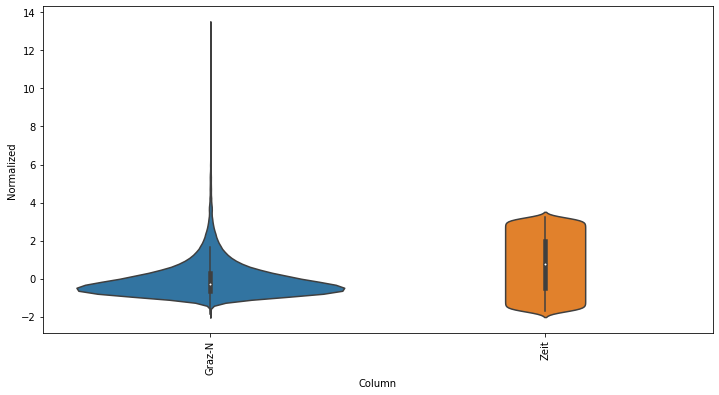

In [12]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

nur wenige starke Ausreisser

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Graz-N,87648.0,2.122419e+01,1.533114e+01,-8.900000e+00,1.140000e+01,1.760000e+01,2.660000e+01,2.429000e+02
Zeit,87648.0,1.498954e+09,4.554350e+07,1.420072e+09,1.459513e+09,1.498954e+09,1.538396e+09,1.577837e+09


# Trainingsvorbereitung




## Data windowing

Um Modelle mit unterschiedlichen Inputs (feature anzahl und sample anzahl) und Outputs (Vorhersagen für einen einzelnen Zeitpunkt oder Verläufe) erstellen zu können, muss man lediglich unterschiedliche Datenfenster erzeugen.

Die Klasse `WindowGenerator` kann aus input länge, offset und output länge ein Datenfenster erzeugen, mit dem das gewünschte Modell trainiert werden kann.

Sie generiert Beispielfenster und kann diese gemeinsam mit oder ohne den Vorhersagen eines Modells in einem Plot darstellen.

In [14]:
class WindowGenerator():
    
  @property
  def train(self):
    return self.make_dataset(self.train_df)
  
  @property
  def val(self):
    return self.make_dataset(self.val_df)
  
  @property
  def test(self):
    return self.make_dataset(self.test_df)
  
  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)
  
    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
  
    return inputs, labels

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=2048,)
  
    ds = ds.map(self.split_window)
  
    return ds

  def plot(self, model=None, plot_col=Ziel, max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(3, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
               label='Inputs', marker='.', zorder=-10)
  
      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index
  
      if label_col_index is None:
        continue
  
      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)
  
      if n == 0:
        plt.legend()
  
    plt.xlabel(Ziel)


## Plot train vs. val

Um den Verlauf des Trainings bewerten zu können (Überanpassung, etc.)

In [15]:
def plot_train_val(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss)+1)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Verlust Training')
    plt.plot(epochs, val_loss, 'b', label='Verlust Validierung')
    plt.title('Wert der Verlustfunktion Training/Validierung')
    plt.legend()
    plt.show()

## Funktion zum trainieren der Modelle
Mit Callback: Training hört bei Überanpassung oder nicht-konvergieren automatisch früher auf

In [16]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

# Modelle

## Modell zur Vorhersage von einem einzelnen Wert innerhalb 24h

Für dieses Modell wird ein Fenster erzeugt, dessen input-feature-vektor die Werte aller features für 24h enthält und dessen label (output) bis zu 24h in der Zukunft liegt und nur den pm10 durchschnitt enthält.

Vorhersage ist damit der vermutete durchschnittliche pm10 Wert von Graz.

## Vergleichsmodell

In [17]:
eingabe_window = WindowGenerator(
    input_width=48, label_width=1, shift=2*Stunden,
    label_columns=[Ziel])

In [18]:
val_performance = {}

Kleinere und größere Modelle, jeweils mit mehr oder weniger features wurden getestet, ohne deutliche Unterschiede in der Vorhersage

In [19]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [20]:
baseline = Baseline(label_index=column_indices[Ziel])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])


val_performance['vergleich_' + Ziel + "_"+ str(Stunden) + 'h'] = baseline.evaluate(eingabe_window.val)


9/9 [==============================] - 0s 6ms/step - loss: 0.6025 - mean_absolute_error: 0.5529


## Lstm mit 32 ohne drop-out

In [21]:
lstm_32_odo = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32), #, return_sequences=True ), tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(units=1)
])

In [22]:
history_lstm_32_odo = compile_and_fit(lstm_32_odo, eingabe_window, patience=5)

IPython.display.clear_output()
val_performance['lstm_32_odo_' + Ziel + "_"+ str(Stunden) + 'h'] = lstm_32_odo.evaluate(eingabe_window.val)

9/9 [==============================] - 1s 127ms/step - loss: 0.3349 - mean_absolute_error: 0.4124


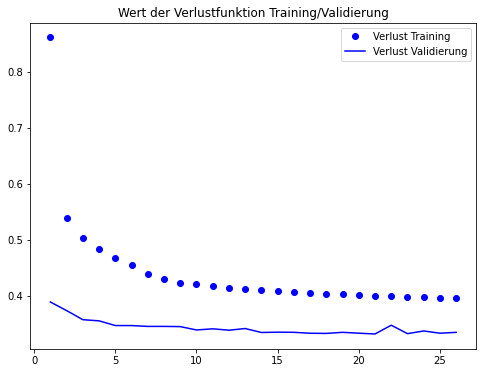

In [23]:
plot_train_val(history_lstm_32_odo)

## Lstm mit 64 ohne drop-out

In [24]:
lstm_64_odo = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64), #, return_sequences=True ), tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(units=1)
])

In [25]:
history_lstm_64_odo = compile_and_fit(lstm_64_odo, eingabe_window, patience=5)

IPython.display.clear_output()
val_performance['lstm_64_odo_' + Ziel + "_"+ str(Stunden) + 'h'] = lstm_64_odo.evaluate(eingabe_window.val)

9/9 [==============================] - 2s 221ms/step - loss: 0.3214 - mean_absolute_error: 0.4005


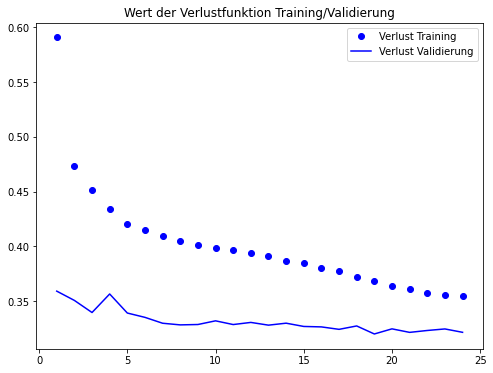

In [26]:
plot_train_val(history_lstm_64_odo)

## Lstm mit 32 + 16 ohne drop-out

In [27]:
lstm_32_16_odo = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True ), 
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(units=1)
])

In [28]:
history_lstm_32_16_odo = compile_and_fit(lstm_32_16_odo, eingabe_window, patience=5)

IPython.display.clear_output()
val_performance['lstm_32+16_odo_' + Ziel + "_" + str(Stunden) + 'h'] = lstm_32_16_odo.evaluate(eingabe_window.val)

9/9 [==============================] - 2s 189ms/step - loss: 0.3363 - mean_absolute_error: 0.4217


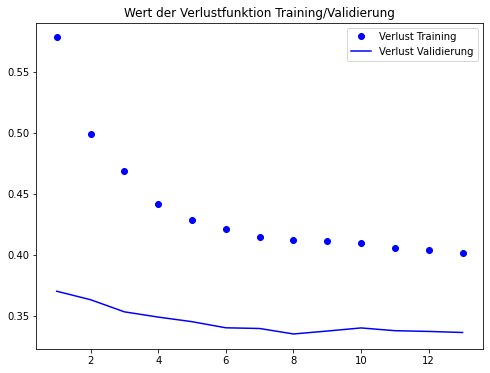

In [29]:
plot_train_val(history_lstm_32_16_odo)

In [30]:
print(Features)
for name, value in val_performance.items():
  print(f'{name:3}: {value[1]:0.4f}')

['Zeit']
vergleich_Graz-N_6h: 0.5529
lstm_32_odo_Graz-N_6h: 0.4124
lstm_64_odo_Graz-N_6h: 0.4005
lstm_32+16_odo_Graz-N_6h: 0.4217
